# IMPORTACION DE LIBRERIAS





In [1]:
#Librerias para la obtencion de los datos
import gzip
import pandas as pd #esta libreria fue empleada tambien en la manipulacion de los df posteriormente
import json
import ast

#Libreria utilizada para el analisis de sentimiento
import nltk
nltk.download('vader_lexicon')
import numpy as np

#Libreria utilizada en la transformacion de fechas
from datetime import datetime

#Librerias utilizadas para cargar y exportar datos desde drive
from google.colab import drive
from google.colab import files

#Librerias para visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

#Libreria para el sistema de recomendacion
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
# Montar Google Drive en Google Colab
drive.mount('/content/drive')

Mounted at /content/drive


# TRANSFORMACION DE LOS ARCHIVOS DEL DATASETS A DATAFRAMES

Los datos estan en formatos de JSON o similares, por lo que deben utilizarse diversas librerias para lograr obtenerlos como un objeto de python y luego poder generar un dataframe a partir de ellos.

## steam_games

In [3]:
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/Data/datasets/steam_games.json.gz'

# en data_list se almacenan los diccionarios generados a partir de cada linea del archivo
data_list = []

with gzip.open(ruta_archivo) as archivo:
    for line in archivo:
        # Se genera un objeto data con cada línea como un objeto JSON y se agrega a la lista
        data = json.loads(line)
        data_list.append(data)

df_steam_games_original = pd.DataFrame(data_list)

## Australian_user_reviews

In [4]:
ruta_archivo = '/content/drive/MyDrive//Colab Notebooks/Data/datasets/user_reviews.json.gz'

# en data_list se almacenan los diccionarios generados a partir de cada linea del archivo
data_list = []

with gzip.open(ruta_archivo) as archivo:
    for line in archivo:

            # Se utiliza ast.literal_eval para convertir cada línea en un diccionario
            data = ast.literal_eval(line.decode('utf-8'))
            data_list.append(data)

df_user_reviews_original = pd.DataFrame(data_list)


# Australian user items

In [5]:
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/Data/datasets/users_items.json.gz'

# en data_list se almacenan los diccionarios generados a partir de cada linea del archivo
data_list = []

with gzip.open(ruta_archivo, 'rt', encoding='utf-8') as archivo:
    for line in archivo:

            # Se utiliza ast.literal_eval para convertir cada línea en un diccionario
            data = ast.literal_eval(line)
            data_list.append(data)

df_users_items_original = pd.DataFrame(data_list)



Se crean unas copias de los df para evitar tener que volver a cargarlos en caso de que se cometa un error posteriormente y se requieran de los df originales.

In [6]:
df_users_items = df_users_items_original.copy()
df_user_reviews = df_user_reviews_original.copy()
df_steam_games = df_steam_games_original.copy()


### Analisis de sentimiento

En primer lugar se expande la columna de reviews para poder aplicar algun metodo de analisis de sentimiento



In [7]:
#Se expanden la columna de reseñas del dataframe
df_exploded = df_user_reviews.explode('reviews')

# Se expanden claves del JSON en nuevas columnas
df_expandido = pd.json_normalize(df_exploded['reviews'])

# Se concatenan las columnas utiles de los df
df_reviews = pd.concat([df_exploded.drop(columns=['reviews','user_url']).reset_index(drop=True), df_expandido], axis=1)

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def analizar_sentimiento(texto): #Se define la funcion que toma un valor y lo clasifica como positivo o negativo
    sia = SentimentIntensityAnalyzer()
    polaridad = sia.polarity_scores(texto)['compound']
    if polaridad>0:
        return 2 #asociado a un sentimiento positivo
    elif polaridad == 0:
        return 1 #asociado a un sentimiento neutro
    else:
        return 0 #asociado a un sentimiento negativo

#Aplicamos la funcion a los elementos del df de reseñas
df_reviews['sentimiento'] = df_reviews['review'].apply(
    lambda x: analizar_sentimiento(x)
        if pd.notna(x)
        else 1) #Esto significa que si no se tiene una reseña, se lo clasifique como neutro

In [9]:
print(df_reviews['sentimiento'].value_counts())

2    37657
1    11844
0     9832
Name: sentimiento, dtype: int64


## PREPARACION DE LOS DATASETS PARA LA API

### UserForGenre

In [10]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


En primer lugar se eliminan los registros donde todos los valores son nulos:

In [11]:
df_steam_games.dropna(how='all', inplace=True)
df_steam_games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88310,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro
88311,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL
88312,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com
88313,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域
88314,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN


#### Imputacion de valores nulos en la columna de genero empleando la columna tags

In [12]:
df_steam_games[['genres','tags']].head(20)
#Se observa que la columna tags presenta muchos elementos que podrian considerarse como generos, pero otros elementos adicionales. Se puede emplear esta lista para llenar los valores nulos de la columna de genero, pero previamente se debe eliminar estos elementos adicionales.

,genres,tags
88310,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]"
88311,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game..."
88312,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind..."
88313,"[Action, Adventure, Casual]","[Action, Adventure, Casual]"
88314,NaN,"[Action, Indie, Casual, Sports]"
88315,"[Action, Adventure, Simulation]","[Action, Adventure, Simulation, FPS, Shooter, ..."
88316,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]"
88317,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]"
88318,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]"
88319,"[Casual, Indie, Racing, Simulation]","[Indie, Casual, Simulation, Racing]"


In [13]:
#Obtener una lista de generos unicos
# Utilizar explode para convertir las listas en filas individuales donde cada fila presenta un unico genero
df_exploded = df_steam_games['genres'].explode()

# Obtener los generos unicos
genres = df_exploded.unique()

print(genres)

['Action' 'Casual' 'Indie' 'Simulation' 'Strategy' 'Free to Play' 'RPG'
 'Sports' 'Adventure' nan 'Racing' 'Early Access' 'Massively Multiplayer'
 'Animation &amp; Modeling' 'Video Production' 'Utilities'
 'Web Publishing' 'Education' 'Software Training'
 'Design &amp; Illustration' 'Audio Production' 'Photo Editing'
 'Accounting']


In [14]:
# Se eliminan todos los elementos de la columna tags que no sean generos, esta columna unicamente se empleara para rellenar los valores nulos de la columna generos.
def filtrar_elementos(lista):
    if type(lista) == list:
        return [elemento for elemento in lista if elemento in genres and elemento not in (['Free to Play', 'Early Acces'])] #devuelve los elementos de la lista que estan presentes en la lista genres y ademas no se consideran algunos elementos ya que no son generos como tal

# Aplicar la función a la columna 'tags' del dataframe
df_steam_games['tags2'] = df_steam_games['tags'].apply(filtrar_elementos)

In [15]:
#Se llena los nulos de la columna genre con los de la columna tags
df_steam_games['genres'] = np.where(df_steam_games['genres'].notna(),
                                    df_steam_games['tags2'], df_steam_games['genres'])


La informacion en la columna de app_name es mas precisa y esta mas completa, y no se puede extraer nada de la columna title, por lo que solo se utilizara la de app_name

In [16]:
df_steam_games[(df_steam_games.app_name != df_steam_games.title) & ((pd.notna(df_steam_games.title))) & (pd.isna(df_steam_games.app_name))]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,tags2


#### Primera seleccion de columnas

Se seleccionan las columnas que se desean tener en cuenta para armar el sistema de recomendacion (dentro de las cuales estan presentes las necesarias para realizar esta consulta)

In [17]:
df_steam_games_ml = df_steam_games[['id','app_name','genres','specs','tags','price','release_date']]

#### Modificacion de la columna release_date para que presente formato de fecha

In [18]:
# Se cambia el tipo de dato de la columna fecha_lanzamiento a datetime
df_steam_games_ml['fecha_lanzamiento'] = pd.to_datetime(df_steam_games_ml['release_date'], errors='coerce')

#Se analiza cuantos valores nulos resultan en la columna fecha_lanzamiento
print('Nulos en columna de fecha_lanzamiento:',df_steam_games_ml['fecha_lanzamiento'].isnull().sum())

#Como el numero de nulos en la fecha_lanzamiento es considerable, se analiza si se perdieron fechas o que valores se tenian en estos registros el la columna fecha_lanzamiento
print('Valores que se tomaron en fecha_lanzamiento como nulos:',df_steam_games_ml['release_date'][df_steam_games_ml['fecha_lanzamiento'].isnull()].unique())

#Como se observa los nulos en fecha_lanzamiento en general indican que el juego todavia no fue lanzado aun o que estan proximos a ser lanzados, ademas de valores que previamente eran nulos, se eliminan estos registros ya que no suman a nuestro analisis ya que nos interesan los juegos que ya fueron jugados
df_steam_games_ml = df_steam_games_ml.dropna(subset='fecha_lanzamiento')

#Se crea una columna con los años donde se lanzo el juego
df_steam_games_ml['year'] = [fecha.year for fecha in df_steam_games_ml['fecha_lanzamiento']]

#Se eliminan las demas columnas relacionadas a la fecha
df_steam_games_ml = df_steam_games_ml.drop(['fecha_lanzamiento','release_date'],axis=1)


Nulos en columna de fecha_lanzamiento: 2241
Valores que se tomaron en fecha_lanzamiento como nulos: [nan 'Soon..' 'Beta测试已开启' 'Coming Soon' 'Q2 2017' 'TBA' "When it's done"
 'coming soon' 'Q2 2018' 'Winter 2017' 'soon' '14 July' 'Summer 2017'
 'Spring 2018' 'Winter 2018' 'To be Announced' 'TBD' 'Fall 2017' 'Q1 2018'
 'Январь 2018' 'Soon' 'First quarter of 2018' 'H2 2018' '2018年初頭発売予定'
 'Please wait warmly' 'early access' 'SOON' 'Coming Soon/Próximamente'
 '2018 [Now get free Pre Alpha]' '1st Quarter 2018' '预热群52756441'
 '2018年1月' 'Coming soon' 'Fall 2018'
 '0̵1̴0̵0̶1̷0̶0̵0̴ ̴0̶0̶1̶1̶0̷0̶1̵1̴ ̸0̶0̶1̶1̵0̶1̷0̴0̵ ̴0̶1̷0̸1̵0̷0̴1̶0̴ ̴0̷0̴1̷1̶0̶1̵1̷1̵ ̵'
 '"""Soon"""' 'Spring 2017' 'Demo coming soon.' 'Coming 2017'
 'Not yet available' "C'est bientôt...                    (ou pas)"
 'Q4 2017' 'Early 2018' 'Datachunks conflicted. Be vigiliant.'
 'Q2 2018 (Tentative)' 'Demo is available now!' 'Play Beta in demo!'
 '2017 Q4' 'Coming Soon!' 'Early Spring 2018' 'TBA 2017' 'To be announced'
 'When 

<ipython-input-18-1caae04995c7>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_steam_games_ml['fecha_lanzamiento'] = pd.to_datetime(df_steam_games_ml['release_date'], errors='coerce')
<ipython-input-18-1caae04995c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steam_games_ml['fecha_lanzamiento'] = pd.to_datetime(df_steam_games_ml['release_date'], errors='coerce')


#### Expansion de columnas que presentan como elementos listas o diccionarios

In [19]:
# Se emplea explode para expandir las listas de generos en la columna genres
df_user_for_genre = df_steam_games_ml.explode('genres')

In [20]:
# Se expande la lista de JSONs que contienen informacion sobre items
df_exploded = df_users_items.explode('items')

# Se expanden las claves del JSON en nuevas columnas
df_expandido = pd.json_normalize(df_exploded['items'])

# Se unen los dataframes dejando unicamente las columnas que nos interesan
df_items = pd.concat([df_exploded.drop(columns=['items_count','steam_id','user_url','items']).reset_index(drop=True), df_expandido], axis=1)

#### Generacion del dataset adecuado para la consulta 1 y 2

In [21]:
#Se seleccionan las columnas que nos sirven para esta consulta. Como son pocos los registos con ids nulos se eliminan.
df_user_for_genre = df_user_for_genre[['id','genres','year']].dropna(subset='id')

# Se combinan los DataFrames en función del id del item
df_user_for_genre = pd.merge(df_user_for_genre, df_items, left_on='id', right_on='item_id', how='inner')

#Se eliminan los valores donde playtime_forever es =0 y ademas, como se encuentra en minutos, se transforma a horas.
df_user_for_genre = df_user_for_genre[df_user_for_genre.playtime_forever != 0]
df_user_for_genre['playtime_forever'] = [round(playtime/60,1) for playtime in df_user_for_genre['playtime_forever'] ]

#Se seleccionan las filas que son utiles para la consulta
df_user_for_genre = df_user_for_genre[['user_id','genres','year','playtime_forever']]


In [22]:
#Se crea un dataframe que presente el tiempo jugado agrupando por user_id, genero y año,
df_user_for_genre = (df_user_for_genre.groupby(['user_id','genres','year']).sum()
                   .reset_index())


Para cada genero se genera una dataframe donde para cada año se informa la cantidad de horas jugadas por el usuario que acumula mas horas de juego.

In [23]:
genres = df_user_for_genre.genres.unique()

df_user_for_genre_API = pd.DataFrame()


for genre in genres:

    df_filtered_by_genre = df_user_for_genre[df_user_for_genre['genres'] == genre]

    # Se calculan las horas jugadas para cada usuario
    user_hours = df_filtered_by_genre.groupby('user_id')['playtime_forever'].sum()

    # Se determina el usuario con mas horas de juego para el genero en cuestion
    max_time_played_user = user_hours.idxmax()

    # Se filtra df_filtered_by_genre para ver los registros del jugador con mas horas de juego
    max_user_df = df_filtered_by_genre[df_filtered_by_genre['user_id'] == max_time_played_user]

    # Se calculan las horas jugadas por año para el usuario principal
    hours_by_year = max_user_df.groupby('year')['playtime_forever'].sum().reset_index()

    # Se agregan al dataframe el genero y el jugador con mayor tiempo de juego
    hours_by_year['genre'] = genre.lower()
    hours_by_year['top_user_id'] = max_time_played_user

    # Se adicionan los datos al dataframe df_user_for_genre_API que presentara los datos de todos los generos
    df_user_for_genre_API = pd.concat([df_user_for_genre_API, hours_by_year], ignore_index=True)

# Visualiza el DataFrame resultante
print(df_user_for_genre_API.head())

   year  playtime_forever   genre top_user_id
0  1995               3.6  action     Sp3ctre
1  1997               4.0  action     Sp3ctre
2  1999               0.7  action     Sp3ctre
3  2000            1177.4  action     Sp3ctre
4  2001               4.2  action     Sp3ctre


In [25]:
def save_data(nombre_archivo, df, index=False):
  ruta_destino = '/content/drive/MyDrive/Colab Notebooks/Data/datasets/' + nombre_archivo + '.csv'

  # Guarda el DataFrame como un archivo CSV en la ruta especificada
  df.to_csv(ruta_destino, index=index)

  files.download(ruta_destino)

In [26]:
save_data('UserForGenre', df_user_for_genre_API)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Playtime Genre

In [27]:
df_user_for_genre

,user_id,genres,year,playtime_forever
0,--000--,Action,2006,15.4
1,--000--,Action,2009,88.8
2,--000--,Action,2010,0.4
3,--000--,Action,2011,108.6
4,--000--,Action,2012,1822.6
...,...,...,...,...
3628394,zzzmidmiss,Strategy,2010,3.4
3628395,zzzmidmiss,Strategy,2011,1.1
3628396,zzzmidmiss,Strategy,2012,15.4
3628397,zzzmidmiss,Strategy,2013,1.5


In [28]:
# Crear un DataFrame vacío para almacenar los resultados
df_play_time_genre_API = pd.DataFrame(columns=['genre', 'top_year'])

# Iterar sobre los géneros
for genre in genres:
    # Filtrar los registros por género
    df_filtered_by_genre = df_user_for_genre[df_user_for_genre['genres'] == genre]

    # Calcular las horas jugadas para cada año
    year_hours = df_filtered_by_genre.groupby('year')['playtime_forever'].sum()

    # Determinar el año que más se jugó para dicho género
    max_time_played_year = year_hours.idxmax()  # Obtener el índice del máximo valor

    # Agregar los datos al DataFrame con los datos de todos los géneros
    df_play_time_genre_API = df_play_time_genre_API.append({'genre': genre.lower(), 'top_year': max_time_played_year}, ignore_index=True)

# Visualizar el DataFrame resultante
print(df_play_time_genre_API.head(10))

<ipython-input-28-f37000186b52>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_play_time_genre_API = df_play_time_genre_API.append({'genre': genre.lower(), 'top_year': max_time_played_year}, ignore_index=True)
<ipython-input-28-f37000186b52>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_play_time_genre_API = df_play_time_genre_API.append({'genre': genre.lower(), 'top_year': max_time_played_year}, ignore_index=True)
<ipython-input-28-f37000186b52>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_play_time_genre_API = df_play_time_genre_API.append({'genre': genre.lower(), 'top_year': max_time_played_year}, ignore_index=True)
<ipython-input-28-f37000186b52>:16: FutureWarning: The frame.append method is depreca

                   genre top_year
0                 action     2012
1              adventure     2006
2                 casual     2015
3           early access     2013
4                  indie     2006
5  massively multiplayer     2006
6                    rpg     2012
7                 racing     2015
8             simulation     2006
9                 sports     2015


<ipython-input-28-f37000186b52>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_play_time_genre_API = df_play_time_genre_API.append({'genre': genre.lower(), 'top_year': max_time_played_year}, ignore_index=True)


In [29]:
save_data('PlayTimeGenre', df_play_time_genre_API)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### UserRecommended

#### Seleccion de columnas

In [30]:
df_user_recommend = df_reviews[['posted','last_edited','item_id','recommend','sentimiento']]

#### Eliminacion de nulos

 Se observa que se tienen registros con todos los valores nulos (menos la de sentimiento que es una columna calculada), por lo que estos registros seran eliminados.

In [31]:
#df_user_recommend[pd.isna(df_user_recommend['recommend'])]

In [32]:
df_user_recommend.dropna(subset='recommend',inplace=True)

<ipython-input-32-a96b88073fde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend.dropna(subset='recommend',inplace=True)


#### Transformacion de la columna posted y last_edited

Con lo siguiente se busca primero modificar el formato de las columnas posted y last edited para poder manipularlos mas facilmente. Luego, se empleara la informacion de ambas columnas para poder obtener una informacion mas precisa, priorizando la informacion contenida en last edited, siempre y cuando se informe el año. De esta manera, se genera una nueva columna empleando la informacion de ambas columnas en formato de datetime. Se emplea la distribucion de los años informados para imputar los años faltantes.

In [33]:
#Se eliminan las palabras posted y last edited de las fechas
df_user_recommend['posted'] = df_user_recommend['posted'].str.replace('Posted ', "")
df_user_recommend['last_edited'] = df_user_recommend['last_edited'].str.replace('Last edited ', "")

<ipython-input-33-f9f0785472fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['posted'] = df_user_recommend['posted'].str.replace('Posted ', "")
<ipython-input-33-f9f0785472fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['last_edited'] = df_user_recommend['last_edited'].str.replace('Last edited ', "")


In [34]:
df_user_recommend[~df_user_recommend.posted.str.contains(',')] #Se filtran los registros y a aquellos que no tienen coma, que son los que debido al formato que presentan los datos, no van a informar el año de posteo.

,posted,last_edited,item_id,recommend,sentimiento
6,February 3.,,248820,True,2
27,May 20.,,730,True,1
28,July 24.,,730,True,2
31,June 16.,,252950,True,2
32,June 11.,,440,True,1
...,...,...,...,...,...
59328,July 10.,,70,True,2
59329,July 8.,,362890,True,2
59330,July 3.,,273110,True,2
59331,July 20.,,730,True,2


Se tiene muchos registros donde no se informa el año del posteo, por lo que se evalua si se puede utilizar la columna last_edited para obtenerlo

In [35]:
df_user_recommend[(df_user_recommend.last_edited != '')
                        & (~df_user_recommend.posted.str.contains(','))
                        & (df_user_recommend.last_edited.str.contains(','))].tail()
                        #Estas dos condiciones son para traer unicamente los registros que no informan el año en posted, pero que si contiene coma(por lo que podrian llegar a informar el año) en last_edited
                        #Se observa que no se tiene ningun registro, asi que no es posible obtener los datos del año de esta forma.

,posted,last_edited,item_id,recommend,sentimiento


In [36]:
df_user_recommend[(df_user_recommend.last_edited != '')
                        & (df_user_recommend.posted.str.contains(','))
                        & (~df_user_recommend.last_edited.str.contains(','))].head()
#Estas dos condiciones son para traer unicamente los registros que no informan el año en last_edited, pero que si contiene coma(por lo que podrian llegar a informar el año) en posted
#Si bien es mejor utilizar las fechas de last_edited cuando sea posible debido a que es la ulitma actualizacion, perderiamos informacion con respecto a los años si no hacemos un tratamiento previo.

,posted,last_edited,item_id,recommend,sentimiento
87,"June 23, 2015.",April 4.,730,True,0
88,"September 11, 2015.",June 23.,570,True,2
195,"June 29, 2014.",June 26.,253710,False,2
216,"July 6, 2015.",March 8.,218620,True,2
361,"August 2, 2014.",March 31.,570,True,2


In [37]:
def str_a_date(fecha): #Funcion que permite cambiar las fechas de la columna posted y last_edited a un formato de fecha.
  if fecha=='':
    return None
  elif "," in fecha: #Si el valor presenta coma, se indicara el año correcto
    return datetime.strptime(fecha, '%B %d, %Y.')
  elif fecha == 'February 29.': #Si la fecha es february 29, como 1900 (que es el año que se toma por defecto el la funcion strptime si la fecha no informa el año) tiene 28 dias, se toma otro año que tenga 29 dias en este mes para que no se salga del rango aceptado el dia
    fecha2= fecha[:-1] + ', 1904.' #1904 es el año bisiesto mas proximo
    return datetime.strptime(fecha2, '%B %d, %Y.')
  else:
    return datetime.strptime(fecha, '%B %d.') #Si solo se informa el dia y mes, se toma un año por defecto de 1900.
  #Tener en cuenta que las fechas que resultan con años de 1900 o 1904 se trataran posteriormente.

In [38]:
#Se aplica la funcion a las columnas de posted y last_edited para crear dos nuevas columnas donde se tendra la fecha pero con formato datetime.
df_user_recommend['posted_date'] = df_user_recommend.posted.apply(lambda date: str_a_date(date))
df_user_recommend['last_edited_date'] = df_user_recommend.last_edited.apply(lambda date: str_a_date(date))
df_user_recommend.head()

<ipython-input-38-fc91d7094968>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['posted_date'] = df_user_recommend.posted.apply(lambda date: str_a_date(date))
<ipython-input-38-fc91d7094968>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['last_edited_date'] = df_user_recommend.last_edited.apply(lambda date: str_a_date(date))


,posted,last_edited,item_id,recommend,sentimiento,posted_date,last_edited_date
0,"November 5, 2011.",,1250,True,2,2011-11-05,NaT
1,"July 15, 2011.",,22200,True,2,2011-07-15,NaT
2,"April 21, 2011.",,43110,True,2,2011-04-21,NaT
3,"June 24, 2014.",,251610,True,2,2014-06-24,NaT
4,"September 8, 2013.",,227300,True,2,2013-09-08,NaT


In [39]:
def aplicar_modificacion(row):
    #Se crea una funcion para seleccionar las columnas last_edited_date o posted_date cuando sea conveniente, generando una nueva columna que presente la informacion mas adecuada para el analisis.
    if pd.notna(row['last_edited_date']):
      day_month_last_edited = row['last_edited_date'].strftime('%d-%m')
      # Se obtiene el año siguiente a posted_date
      year_next_posted = row['posted_date'].year

    if pd.isna(row['last_edited_date']) or (row['last_edited_date'].day==29 and row['last_edited_date'].month==2):
        return row['posted_date'] #Cuando no se tenga datos en last_edited, o el dato sea un 29 de febrero, se tomara como dato la fecha en post_date
    elif not row['last_edited_date'].year in [1900, 1904]:
        return row['last_edited_date'] #Cuando se haya informado el año en last_edited, se tomara esta fecha
    elif (row['last_edited_date'].month < row['posted_date'].month) and (not row['posted_date'].year in [1900, 1904]):
        return pd.to_datetime(day_month_last_edited + '-' + str(year_next_posted+1), format='%d-%m-%Y') # Cuando se informe el año en posted, y ademas el mes en posted sea posterior al mes en last_edited, se tomara el mes y dia de last_edited, pero el año siguiente de la fecha en la columna posted.
    else:
        return pd.to_datetime(day_month_last_edited + '-' + str(year_next_posted), format='%d-%m-%Y') # Cuando se informe el año en posted, y ademas el mes de la fecha el posted sea anterior al mes de la fecha en last_edited, se tomara el mes y dia de la fecha last_edited, pero el año de la fecha en la columna posted
#Tener en cuenta que lo ultimo es un criterio adoptado, ya que no necesariamente es algo que deberia cumplirse.

df_user_recommend['date'] = df_user_recommend.apply(aplicar_modificacion, axis=1)

<ipython-input-39-1b5ddf838ed2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['date'] = df_user_recommend.apply(aplicar_modificacion, axis=1)


In [40]:
# Se va a imputar los años faltantes teniendo en cuenta la distribución de los datos en donde el año se informa
x = df_user_recommend[~df_user_recommend['date'].dt.year.isin([1900,1904])].date.dt.year #Se obtienen los años que fueron informados

#Se crea una mascara para filtrar los registros donde no se informo el año en posted
mask = df_user_recommend.date.dt.year.isin([1900,1904])

year_mean = x.mean()
year_median = x.median()
year_std = x.std()

# Se seleccionan las filas donde no hay fecha informada
imputation_indices = df_user_recommend[mask].index

# En base a la distribucion de los datos conocidos, se generan los años con los que se va a imputar el df
imputed_values = np.random.randint(low=int(year_mean - 2*year_std), high=int(year_mean + 2*year_std), size=len(imputation_indices))

imputed_dates = pd.Series(imputed_values, index=imputation_indices)

imputed_dates = imputed_dates.reindex(df_user_recommend.index) #Esto se realiza para que df_user_recommend y imputed_dates presenten los mismos indices y se pueda agregar imputed dates a df_user_recommend como columna

df_user_recommend['imputed_year'] = imputed_dates.fillna(0).astype(int)

# Concatenar los valores imputados con los valores existentes en la columna 'date'
df_user_recommend['date'] = df_user_recommend.apply(lambda row: row['date'].replace(year=int(2012))
                                                                  if (row['date'].month == 2 and (row.date.day == 29)) #Se toma el año bisiesto que mas datos presenta en el dataset para imputar los datos del años con fecha de 29 de febrero
                                                                  else(row['date'].replace(year=row['imputed_year'])
                                                                  if row.date.year in(1900,1904)
                                                                  else row['date']), axis=1)

<ipython-input-40-b3139fb1bab5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['imputed_year'] = imputed_dates.fillna(0).astype(int)
<ipython-input-40-b3139fb1bab5>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['date'] = df_user_recommend.apply(lambda row: row['date'].replace(year=int(2012))


(array([   53.,   471.,     0.,  4438.,     0.,  9617., 25199.,     0.,
        19176.,   351.]),
 array([2010. , 2010.6, 2011.2, 2011.8, 2012.4, 2013. , 2013.6, 2014.2,
        2014.8, 2015.4, 2016. ]),
 <BarContainer object of 10 artists>)

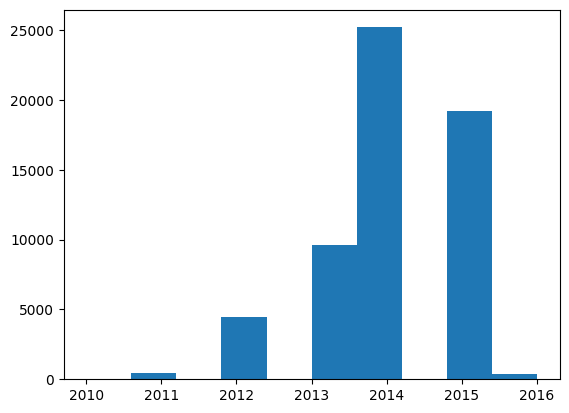

In [41]:
plt.hist(df_user_recommend.date.dt.year)
plt.title('Registros para cada año informado e imputados')
plt.xlabel('Año')
plt.ylabel('conteo')
plt.show()

(array([   53.,   471.,     0.,  1027.,     0.,  6215., 21893.,     0.,
        19176.,   351.]),
 array([2010. , 2010.6, 2011.2, 2011.8, 2012.4, 2013. , 2013.6, 2014.2,
        2014.8, 2015.4, 2016. ]),
 <BarContainer object of 10 artists>)

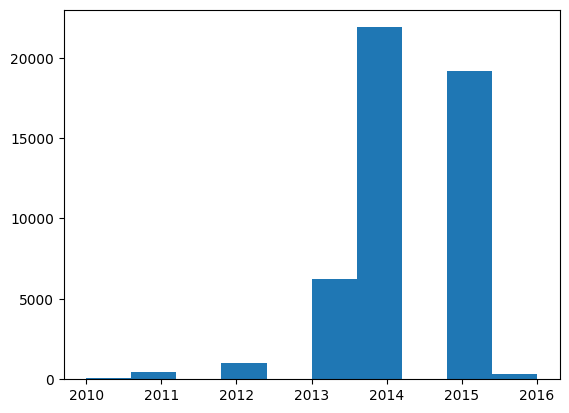

In [42]:
plt.hist(x)
plt.title('Registros para cada año informado')
plt.xlabel('Año')
plt.ylabel('conteo')
plt.show()

Se observa que modificamos muy poco la distribucion original, por lo que se considera que puede ser una buena aproximacion para imputar los años faltantes.

#### Seleccion de columnas para el analisis

In [43]:
df_user_recommend.drop(['posted','last_edited','posted_date','last_edited_date','imputed_year'],axis=1,inplace=True)
df_user_recommend.head()

<ipython-input-43-6cb22147b649>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend.drop(['posted','last_edited','posted_date','last_edited_date','imputed_year'],axis=1,inplace=True)


,item_id,recommend,sentimiento,date
0,1250,True,2,2011-11-05
1,22200,True,2,2011-07-15
2,43110,True,2,2011-04-21
3,251610,True,2,2014-06-24
4,227300,True,2,2013-09-08


In [44]:
# Se combinan los DataFrames en función del id del juego
df_user_recommend = pd.merge(df_steam_games, df_user_recommend, left_on='id', right_on='item_id', how='inner')

In [45]:
df_user_recommend = df_user_recommend[['date','app_name','recommend','sentimiento']]

In [46]:
df_user_recommend['year'] = df_user_recommend.date.dt.year
df_user_recommend

,date,app_name,recommend,sentimiento,year
0,2014-01-12,Carmageddon Max Pack,True,1,2014
1,2015-10-28,Half-Life,True,2,2015
2,2011-01-27,Half-Life,True,0,2011
3,2014-07-01,Half-Life,True,2,2014
4,2013-12-06,Half-Life,True,2,2013
...,...,...,...,...,...
53983,2014-10-26,Counter-Strike: Condition Zero,False,1,2014
53984,2013-12-08,Counter-Strike: Condition Zero,True,2,2013
53985,2015-01-05,Counter-Strike: Condition Zero,True,1,2015
53986,2014-10-31,Counter-Strike: Condition Zero,True,1,2014


Hasta este punto el dataset puede ser utilizado para la consulta 3 y 4. A partir de aqui nos centraremos en modificarlo para obtener el dataset necesario para la consulta 3.

Primero, se filtra el dataframe para obtener unicamente los registros donde se cumple que el juego fue recomendado (recommend=True) y ademas el sentimiento fue positivo o neutro(1 o 2). Luego se aplica una funcion al dataset para obtener el top 3 de juegos recomendados por año.

In [47]:
df_user_recommend_API = df_user_recommend[(df_user_recommend.recommend) & (df_user_recommend.sentimiento.isin([1,2]))]  #Se filtran los registros que cumplen con la condicion para peretenecer al top 3 de juegos mas recomendados
df_user_recommend_API = df_user_recommend_API[['year','app_name','recommend']] #Se utiliza una unica columna entre recommend y sentimiento ya que se hara un conteo y no proporcionara data adicional mantener las 2

def top3(df_user_recommend_API):
  return (df_user_recommend_API.groupby(['year', 'app_name']).count() #cantidad de recomendaciones para cada juego en cada año
                            .groupby('year').apply(lambda x: x.nlargest(3, columns='recommend')) # tres juegos con el mayor número de recomendaciones para cada año
                            .reset_index(level=1, drop=True)
                            .drop('recommend',axis=1))

df_user_recommend_API = top3(df_user_recommend_API)
df_user_recommend_API

Empty DataFrame
Columns: []
Index: [(2010, Killing Floor), (2010, Team Fortress 2), (2010, Alien Swarm), (2011, Team Fortress 2), (2011, Portal 2), (2011, Garry's Mod), (2012, Team Fortress 2), (2012, Counter-Strike: Global Offensive), (2012, Dota 2), (2013, Team Fortress 2), (2013, Garry's Mod), (2013, Counter-Strike: Global Offensive), (2014, Team Fortress 2), (2014, Counter-Strike: Global Offensive), (2014, Garry's Mod), (2015, Counter-Strike: Global Offensive), (2015, Team Fortress 2), (2015, Garry's Mod), (2016, Counter-Strike: Global Offensive), (2016, PAYDAY 2), (2016, Dota 2)]

In [48]:
save_data('UserRecommend',df_user_recommend_API,True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### UsersNotRecommend

In [49]:
#Se procede de manera similar que apra UsersRecommend
df_user_not_recommend_API = df_user_recommend[(~df_user_recommend.recommend) & (df_user_recommend.sentimiento == 0)]  #Se filtran los registros que cumplen con la condicion para peretenecer al top 3 de juegos mas recomendados
df_user_not_recommend_API = df_user_not_recommend_API[['year','app_name','recommend']] #Se utiliza una unica columna entre recommend y sentimiento ya que se hara un conteo y no proporcionara data adicional mantener las 2
df_user_not_recommend_API = top3(df_user_not_recommend_API)
df_user_not_recommend_API

Empty DataFrame
Columns: []
Index: [(2012, No Man's Sky), (2012, Counter-Strike: Global Offensive), (2012, Robocraft), (2013, No Man's Sky), (2013, Counter-Strike: Global Offensive), (2013, Team Fortress 2), (2014, Counter-Strike: Global Offensive), (2014, DayZ), (2014, Team Fortress 2), (2015, PAYDAY 2), (2015, Counter-Strike: Global Offensive), (2015, DayZ), (2016, Counter-Strike: Global Offensive), (2016, Killing Floor 2), (2016, Mortal Kombat X)]

In [50]:
save_data('UserNotRecommend',df_user_not_recommend_API,True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### sentiment_analysis

Debemos obtener un dataset que según el año de lanzamiento, se devuelve una lista con la cantidad de reseñas positivas negativas o neutras.

#### Seleccion de columnas

In [51]:
df_sentiment_analisis = df_user_recommend[['year','sentimiento']]


#### Conteo de reseñas positivas, negativas y neutras por año.

In [52]:
df_sentiment_analisis_API = pd.DataFrame(df_sentiment_analisis.groupby(['year','sentimiento']).size()).rename(columns={0:'conteo'}) # Con size se calcula el numero de filas en cada grupo (discriminado por año y sentimiento)
df_sentiment_analisis_API.head()

conteo
year sentimiento        
2010 0                 8
     1                 6
     2                36
2011 0                40
     1                60

In [53]:
save_data('sentiment_analysis',df_sentiment_analisis_API,True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## SISTEMA DE RECOMENDACION

### Determinacion de variables importantes

Mediante una nube de palabras, se determinara que es lo que mas comentan los jugadores sobre los juegos para poder seleccionar adecuadamente las caracteristicas que van a determinar la seleccion de los juegos recomendados.

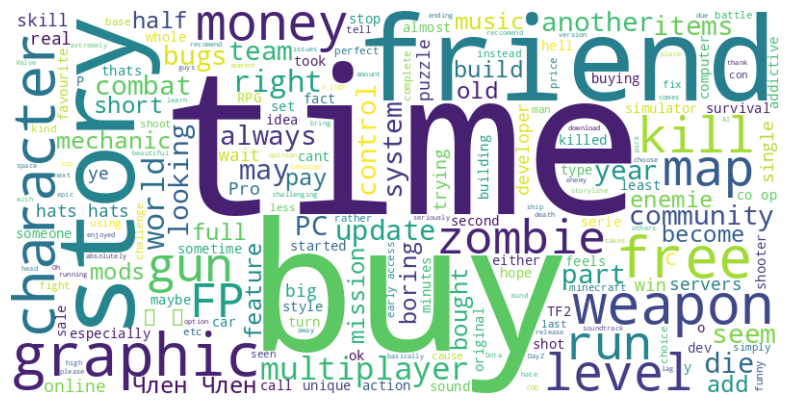

['time', 'buy', 'friend', 'story', 'graphic', 'character', 'free', 'weapon', 'money', 'map', 'level', 'kill', 'run', 'gun', 'zombie', 'FP', 'multiplayer', 'world', 'right', 'update', 'may', 'die', 'another', 'team', 'community', 'always', 'combat', 'looking', 'PC', 'year', 'bugs', 'control', 'seem', 'system', 'part', 'items', 'mechanic', 'full', 'music', 'enemie', 'Член Член', 'old', 'half', 'ㅤ ㅤ', 'become', 'mission', 'boring', 'short', 'pay', 'add']


In [54]:
from wordcloud import WordCloud, STOPWORDS

# Se utilizan las stopwords de la libreria wordcloud, y ademas se adicionan algunas palabras a la lista que son mas especificas para este dataset de juegos.
stopwords = set(STOPWORDS)

custom_stop_words = custom_stop_words = ['game', 'play', 'playing', 'steam', 'good', 'great',
    'fun', 'like', 'really', 'love', 'best',
    'awesome', 'amazing', 'recommend', 'enjoy', 'better',
    'worth', 'cool', 'fantastic', 'excellent', 'favorite',
    'nice', 'loved', 'interesting', 'highly', 'happy',
    'review', 'bad', 'reviewed',
    'experience', 'played', 'hour', 'hours',
    'worthwhile', 'problem', 'issue',
    'played', 'spent', 'waste',
    'one', 'make', 'games', 'will', 'much', 'still',
    'even', 'people', 'want', 'now', 'thing',
    'gameplay', 'lot', 'well', 'need', 'feel', 'player',
    'way', 'first', 'go', 'got', 'say',
    'think', 'give', 'made', 'HAT',
    'see', 'look', 'take', 'find', 'many',
    'know', 'start', 'use', 'pretty', 'NYAN',
    'work', 'u', 'new',
    'though', 'little', 'server', 'bit', 'mod',
    'hard', 'D', 'DLC', 'going', 'far',
    'everything', 'try', 'something',
    'back', 'come', 'life', 'Overall', 'must', 'quite',
    'never', 'e', 'around', 'day', 'long', 'every',
    'ing', 'bug', 'dont', 'end', 'keep', 'getting',
    'point', 'item', 'actually', 'anyone', 'different',
    'everyone', 'easy', 'put', 'stuff',
    'enough', 'times', 'found', 'mode',
    'alot', 'things', 'players', 'makes', 'right'
    'may', 'let', 'alway', 'probably', 'another'
    'looking', 'guy', 'without', 'yet', 'seem'
    'part', 'nothing', 'content', 'used',
    'sure', 'lots', 'making', 'simple', 'although',
    'change', 'de', 'definitely', 'help', 'fan',
    'anything', 'mean', 'thought', 'minute',
    'ㅤ ㅤ', 'im', 's', 'reason', 'two', 'needs',
    'able', 'might','looks', 'enjoyable',
    'already','done', 'gets', 'said', 'C'
    'ye']

stopwords.update(custom_stop_words)

# Se concatenan las reseñas para aplicar al str resultante la nube de palabras
texto = ' '.join(df_reviews['review'].dropna())

# Se crea un objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(texto)

#Se grafica la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Se emplea el objeto de WordCloud para determinar un listado de las palabras mas importantes
frequencies = wordcloud.words_
top_words = list(frequencies.keys())
top_frequencies = list(frequencies.values())
print(top_words[:50])

Se seleccionaron algunas palabras de las 50 mas importantes y se las categorizaron en diferentes grupos:

- Aspectos del juego: story, map, character, level, items, music, graphic, mission, real, short, FP (posiblemente "First Person")..

- Caracteristicas del genero: weapon, kill, run, gun, zombie, combat, enemies, die.

- Multijugador y comunidad: multiplayer, team, community, friend.

- Sistema y actualizaciones: system, control, bugs, time, update, PC.

- Antiguedad: old, year.

- Aspectos economicos: free, pay, half, full, buy, money.

Los aspectos economicos por ejemplo, pueden deducirse de la columna price, ya que en la misma se indica el precio o si el juego es gratuito.





##### Generos mas importantes

In [55]:
important_genres = df_steam_games_ml.genres.explode().value_counts()
important_genres[important_genres>5000].sum()/important_genres.sum()

0.908891887426337

Nos quedamos con los generos mas relevantes para nuestro estudio, considerando que de esta forma se tendra en cuenta casi el 91% de la informacion referida a los generos y se reduce significativamente las filas para aplicar OneHotEncoding.

In [56]:
important_genres=list(important_genres[important_genres >5000].index)
important_genres

['Indie', 'Action', 'Adventure', 'Casual', 'Strategy', 'Simulation', 'RPG']

##### Especificaciones mas importantes

En base a lo que se obtuvo de la nube de palabras, se puede deducir por ejemplo que es importante conocer por ejemplo si el juego es multi o single player. Esta informacion la determinaremos a partir de la columna specs.

In [57]:
important_specs = ['Single-player','Multi-player' ]
df_steam_games_ml.specs.explode().value_counts('specs')

Single-player                 0.199877
Steam Achievements            0.122893
Downloadable Content          0.098770
Steam Trading Cards           0.093130
Steam Cloud                   0.075804
Multi-player                  0.062243
Full controller support       0.054986
Partial Controller Support    0.049534
Steam Leaderboards            0.044823
Co-op                         0.032785
Shared/Split Screen           0.030301
Cross-Platform Multiplayer    0.019162
Stats                         0.017037
Online Multi-Player           0.016686
Steam Workshop                0.014186
Captions available            0.012530
Includes level editor         0.010382
Local Multi-Player            0.008804
MMO                           0.007210
In-App Purchases              0.007132
Online Co-op                  0.007101
Local Co-op                   0.005437
Valve Anti-Cheat enabled      0.003593
Game demo                     0.002781
Commentary available          0.001469
Steam Turn Notifications 

##### Tags mas importantes

Para obtener mas informacion relacionada a las palabras de la nube, se empleara la columna tags:

- Music: Great Soundtrack
- Map: Open World
- FP: First-Person, FPS
- Zombies: Zombies
- story: Story rich
- weapon, kill, gun: Shooter


In [58]:
df_steam_games_ml.tags.explode().value_counts().head(60)

Indie                    16235
Action                   11950
Adventure                 9161
Casual                    8825
Strategy                  7322
Simulation                7022
RPG                       5754
Singleplayer              4191
Multiplayer               2271
Free to Play              2225
Great Soundtrack          2171
Puzzle                    2005
2D                        1938
Atmospheric               1836
Early Access              1434
Platformer                1429
Story Rich                1408
Fantasy                   1330
Sports                    1314
Sci-fi                    1292
Anime                     1270
Open World                1269
Difficult                 1268
Horror                    1241
Massively Multiplayer     1240
Pixel Graphics            1232
Co-op                     1193
Female Protagonist        1157
Shooter                   1139
Racing                    1122
Funny                     1069
First-Person               970
Retro   

In [59]:
important_tags = ['Great Soundtrack', 'Open World', 'First-Person', 'FPS', 'Zombies', 'Story Rich', 'Shooter']

In [60]:
df_ml = df_steam_games_ml.copy()

def filtrar_elementos2(lista_elementos, lista_elementos_interes):
    if type(lista_elementos) == list:
        return [elemento for elemento in lista_elementos if elemento in lista_elementos_interes]

df_ml['specs'] = df_steam_games['specs'].apply(lambda spec: filtrar_elementos2(spec, important_specs))
df_ml['genres'] = df_steam_games['genres'].apply(lambda spec: filtrar_elementos2(spec, important_genres))
df_ml['tags'] = df_steam_games['tags'].apply(lambda spec: filtrar_elementos2(spec, important_tags))

In [61]:
df_ml.specs.value_counts()

[Single-player]                  19557
[Single-player, Multi-player]     6030
[Multi-player]                    1938
[]                                1700
Name: specs, dtype: int64

In [62]:
df_ml.genres.value_counts()

[Action]                                          1803
[Simulation]                                      1717
[Action, Indie]                                   1455
[Casual, Simulation]                              1370
[]                                                 992
                                                  ... 
[RPG, Strategy, Adventure, Simulation, Action]       1
[Action, Simulation, Strategy, Casual]               1
[Action, Casual, Simulation, Strategy]               1
[Simulation, Indie, Adventure, Action, Casual]       1
[Casual, Simulation, RPG, Adventure]                 1
Name: genres, Length: 1416, dtype: int64

In [63]:
df_ml.tags.value_counts()

[]                                                                     24718
[Great Soundtrack]                                                      1051
[Open World]                                                             550
[Story Rich]                                                             525
[Shooter]                                                                312
                                                                       ...  
[Open World, Great Soundtrack, First-Person, FPS]                          1
[Shooter, FPS, Zombies]                                                    1
[First-Person, Zombies, Story Rich, FPS, Shooter]                          1
[Open World, Story Rich, FPS]                                              1
[FPS, First-Person, Story Rich, Shooter, Zombies, Great Soundtrack]        1
Name: tags, Length: 360, dtype: int64

Se puede observar que la columna tags, con el filtrado realizado considerando los intereses de los usuarios, no brinda mucha informacion. Por tal motivo no sera utilizada para el sistema de recomendacion.
Por otra parte, se observa que con el filtrado que hicimos en las columnas de specs y genres, permanece gran parte de la informacion.

#### Filtrado para obtener unicamente los juegos mas recomendados para el sistema de recomendacion

A continuacion, como no se lograria un buen filtrado de los datos unicamente con lo anterior, se va a filtrar en base a si fueron o no recomendados por los usuarios:

In [64]:
conteo_recomendados = df_user_recommend[(df_user_recommend.recommend) & (df_user_recommend.sentimiento.isin([2]))].groupby('app_name').count()
conteo_no_recomendados = df_user_recommend[(~df_user_recommend.recommend) & (df_user_recommend.sentimiento.isin([0]))].groupby('app_name').count()
conteo_recomendados = conteo_recomendados['recommend']
conteo_recomendados.name = 'conteo_recomendados'

conteo_no_recomendados = conteo_no_recomendados['recommend']
conteo_no_recomendados.name = 'conteo_no_recomendados'

df_recomendados_no_recomendados = pd.concat([conteo_recomendados, conteo_no_recomendados], axis=1, keys=['conteo_recomendados', 'conteo_no_recomendados'])
df_recomendados_no_recomendados.conteo_recomendados.fillna(0,inplace=True)
df_recomendados_no_recomendados.conteo_no_recomendados.fillna(0,inplace=True) #Se rellenan los nulos con 0 para poder comparar ambas columnas posteriormente
df_juegos_mas_importantes = df_recomendados_no_recomendados[df_recomendados_no_recomendados['conteo_recomendados'] > df_recomendados_no_recomendados['conteo_no_recomendados']]
juegos_mas_importantes = list(df_recomendados_no_recomendados.index)

Se filtra el dataset para que se obtengan registros solo con los juegos recomendados.

In [65]:
df_ml = df_ml[df_ml.app_name.isin(juegos_mas_importantes)].drop('tags',axis=1)

Se eliminan los registros donde el genero es nulo, ya que es una de las features mas importante para la recomendacion

In [66]:
df_ml.dropna(subset=['genres'],inplace=True)

#### Transformacion de la columna precios

Se analiza que valores que no son flotantes se tiene en la columna de precios

In [67]:
no_float = []

for x in df_ml.price:
  if type(x)!=float:
    if x not in no_float:
      no_float.append(x)
print(no_float)

['Free', 'Free to Play', 'Play for Free!', 'Free To Play', 'Install Now', 'Play WARMACHINE: Tactics Demo', 'Free Mod', 'Free HITMAN™ Holiday Pack', 'Play the Demo', 'Third-party']


Se observa que se tienen valores que incluyen la palabra free, por lo que seria logico reemplazarlos por un precio de 0.
Por otro lado se tienen valores como install now, install theme, etc. Al no tener mas informacion, se considera que se trata de juegos gratis tambien.


In [68]:
# Se por 0 el resto de los valores que no son numericos
df_ml['price'] = df_ml['price'].apply(lambda x: 0.0 if type(x) == str else x)

In [69]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2621 entries, 88338 to 120427
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2620 non-null   object 
 1   app_name  2621 non-null   object 
 2   genres    2621 non-null   object 
 3   specs     2611 non-null   object 
 4   price     2537 non-null   float64
 5   year      2621 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 143.3+ KB


### Imputacion de valores faltantes para la columna precio

<Axes: ylabel='price'>

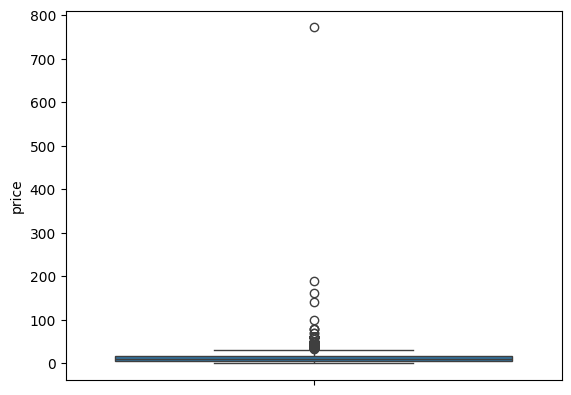

In [70]:
sns.boxplot(df_ml.price)
plt.title('Grafico de caja para el precio de los juegos')
plt.ylabel('precio(usd)')
plt.show()

(array([981., 916., 372., 155.,  14.,  52.,  21.,  16.,   0.,   2.,   3.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  0.    ,   7.7171,  15.4342,  23.1513,  30.8684,  38.5855,
         46.3026,  54.0197,  61.7368,  69.4539,  77.171 ,  84.8881,
         92.6052, 100.3223, 108.0394, 115.7565, 123.4736, 131.1907,
        138.9078, 146.6249, 154.342 , 162.0591, 169.7762, 177.4933,
        185.2104, 192.9275, 200.6446, 208.3617

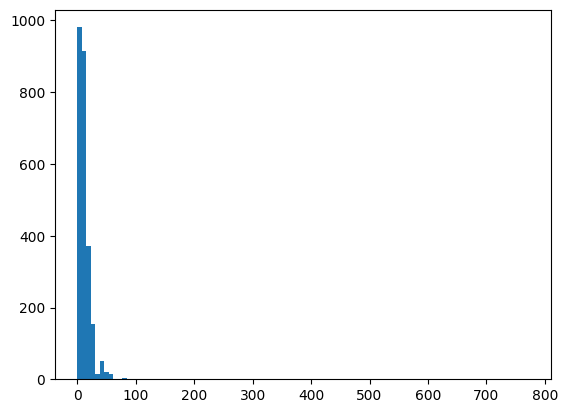

In [71]:
plt.hist(df_ml.price,bins=100)
plt.title('Histograma para el precio de los juegos')
plt.xlabel('precio(usd)')
plt.ylabel('conteo')
plt.show()

In [72]:
df_ml.price.quantile(0.95)

29.99

Los outliers no permiten observar claramente el grafico, ademas se puede ver que el 95% de los juegos presenta un precio inferior a los 30 usd. Por tal motivo, se filtraran los registros para observar graficamente como se comporta el precio de los mismos.

<Axes: ylabel='price'>

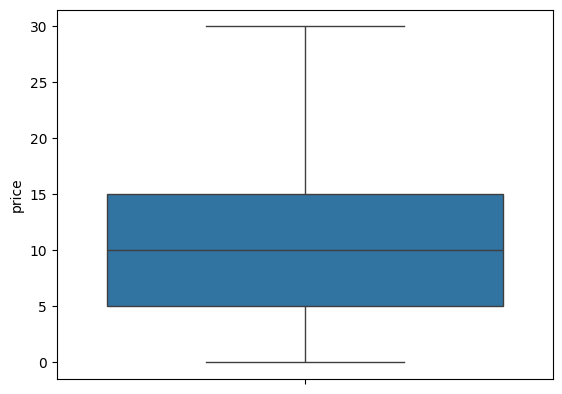

In [73]:
sns.boxplot(df_ml[df_ml.price<30].price)
plt.title('Grafico de caja para el precio de los juegos')
plt.ylabel('precio(usd)')
plt.show()

(array([550., 431., 568., 347.,  23., 350.,  51., 104.]),
 array([ 0.     ,  3.74875,  7.4975 , 11.24625, 14.995  , 18.74375,
        22.4925 , 26.24125, 29.99   ]),
 <BarContainer object of 8 artists>)

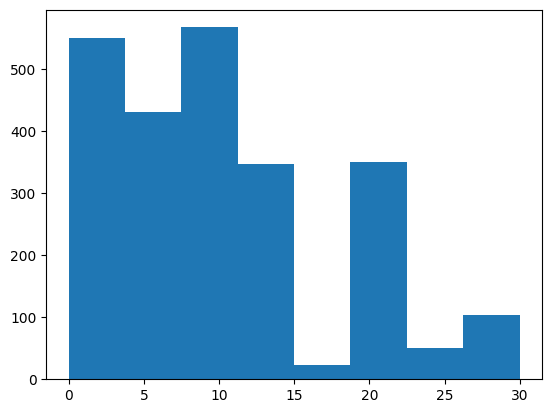

In [74]:
plt.hist(df_ml[df_ml.price<30].price,bins=8)
plt.title('Histograma para el precio de los juegos')
plt.ylabel('conteo')
plt.xlabel('precio(usd)')
plt.show()

In [75]:
df_ml.price.describe()

count    2537.000000
mean       12.410339
std        19.357538
min         0.000000
25%         4.990000
50%         9.990000
75%        15.990000
max       771.710000
Name: price, dtype: float64

Se van a filtrar los registros para observar principalmente alguno de los outliers. Se toma como 80 usd el limite ya que se tiene conociiento de juegos que debido a que son versiones full o premium alcanzan hasta este precio. Por encima de este valor, parecen valores muy elevados por lo que podria tratarse de errores y se estudian en mayor profundidad

In [ ]:
df_ml[df_ml.price>80]

Los que fueron encontrados en la plataforma presentan el precio informado, por lo que no se trata de errores y no se debera realizar algun tipo de correccion. Esto puede deberse debido a que por ejemplo el que sale mas de 700 dls se trata de simulaciones de vuelos de avion que pueden requerir de un arduo y costoso proceso de creacion, ademas de que se tiene en un juego diferentes simulaciones lo que eleva aun mas el costo.

Por otra parte, de la grafica, podemos observar que los precios presentan una distribución sesgada hacia la derecha. Esto indica que hay una concentración de precios más bajos y relativamente pocos valores muy altos.
El precio promedio es mayor que la mediana debido a que los precios extremadamente altos (outliers) en la cola derecha de la distribución aumentan la media, mientras que la mediana no se ve tan afectada por estos valores atípicos. Por lo anterior, se empleara la mediana para imputar los precios nulos.

In [ ]:
median_price = df_ml.price.median()
median_price

9.99

In [ ]:
df_ml['price'] = df_ml.price.apply(lambda x: x if pd.notna(x) else median_price)

#### Imputacion y eliminacion de nulos

In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2621 entries, 88338 to 120427
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2620 non-null   object 
 1   app_name  2621 non-null   object 
 2   genres    2621 non-null   object 
 3   specs     2611 non-null   object 
 4   price     2621 non-null   float64
 5   year      2621 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 143.3+ KB


In [ ]:
df_ml[pd.isna(df_ml.id) | pd.isna(df_ml.app_name)]

,id,app_name,genres,specs,price,year
119271,NaN,Batman: Arkham City - Game of the Year Edition,"[Action, Adventure]",[Single-player],19.99,2012


Se tiene un unico registro con id nulo, por lo que se eliminara. Por otro lado, en la columna de specs se imputaran seleccionando "otro".

In [ ]:
df_ml.dropna(subset='id',inplace=True)

In [ ]:
df_ml['specs'].fillna('Otro', inplace=True)

In [ ]:
df_ml

,id,app_name,genres,specs,price,year
88338,70,Half-Life,"[Action, Adventure]","[Single-player, Multi-player]",9.99,1998
88351,2400,The Ship: Murder Party,"[Indie, Action, RPG, Simulation, Strategy, Adv...","[Single-player, Multi-player]",9.99,2006
88365,3800,Advent Rising,[Action],[Single-player],9.99,2005
88366,1520,DEFCON,"[Strategy, Indie, Simulation]","[Single-player, Multi-player]",9.99,2006
88367,2420,The Ship: Single Player,"[Action, RPG, Indie]",[Single-player],9.99,2006
...,...,...,...,...,...,...
120418,40,Deathmatch Classic,[Action],[Multi-player],4.99,2001
120419,130,Half-Life: Blue Shift,"[Action, Adventure]",[Single-player],4.99,2001
120424,30,Day of Defeat,[Action],[Multi-player],4.99,2003
120426,13230,Unreal Tournament 2004: Editor's Choice Edition,"[Action, Adventure, RPG]","[Single-player, Multi-player]",14.99,2004


#### Tratamiento de ids duplicados

A continuacion tambien nos cercioramos de que no existan juegos duplicados en la data.

In [ ]:
df_ml[df_ml.duplicated(subset='id')]

,id,app_name,genres,specs,price,year


#### Expansion de la columna genero y especificaciones

Por ultimo expandimos las filas de genre y specs para desplegar las listas correspondientes:

In [ ]:
df_ml_exploded = df_ml.explode('genres').explode('specs')

In [ ]:
df_ml_exploded.head()

,id,app_name,genres,specs,price,year
88338,70,Half-Life,Action,Single-player,9.99,1998
88338,70,Half-Life,Action,Multi-player,9.99,1998
88338,70,Half-Life,Adventure,Single-player,9.99,1998
88338,70,Half-Life,Adventure,Multi-player,9.99,1998
88351,2400,The Ship: Murder Party,Indie,Single-player,9.99,2006


#### Tratamiento de variables categoricas

A continuacion, empleando OneHotEncoder, se transformaran las variables categoricas para que puedan ser utilizadas en el modelo para el sistema de recomendacion.  

In [ ]:
df_ml_exploded_dummie = pd.concat([df_ml_exploded,pd.get_dummies(df_ml_exploded, columns=['genres', 'specs']).drop(['year','price','id','app_name'],axis=1)],axis=1)

In [ ]:
df_ml_exploded_dummie

,id,app_name,genres,specs,price,year,genres_Action,genres_Adventure,genres_Casual,genres_Indie,genres_RPG,genres_Simulation,genres_Strategy,specs_Multi-player,specs_Otro,specs_Single-player
88338,70,Half-Life,Action,Single-player,9.99,1998,1,0,0,0,0,0,0,0,0,1
88338,70,Half-Life,Action,Multi-player,9.99,1998,1,0,0,0,0,0,0,1,0,0
88338,70,Half-Life,Adventure,Single-player,9.99,1998,0,1,0,0,0,0,0,0,0,1
88338,70,Half-Life,Adventure,Multi-player,9.99,1998,0,1,0,0,0,0,0,1,0,0
88351,2400,The Ship: Murder Party,Indie,Single-player,9.99,2006,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120427,80,Counter-Strike: Condition Zero,Strategy,Multi-player,9.99,2004,0,0,0,0,0,0,1,1,0,0
120427,80,Counter-Strike: Condition Zero,Adventure,Single-player,9.99,2004,0,1,0,0,0,0,0,0,0,1
120427,80,Counter-Strike: Condition Zero,Adventure,Multi-player,9.99,2004,0,1,0,0,0,0,0,1,0,0
120427,80,Counter-Strike: Condition Zero,Simulation,Single-player,9.99,2004,0,0,0,0,0,1,0,0,0,1


In [ ]:
df_ml_exploded_dummie = df_ml_exploded_dummie.drop(['genres','specs'],axis=1)


Se obtiene un listado de juego con todos los generos a los que pertenece

In [ ]:
df_ml_final = df_ml_exploded_dummie.groupby(['id','app_name', 'price', 'year']).sum().reset_index()

#### Escalado de los datos

Se escalan los datos ya que se trabaja con el modelo de la similitud del coseno, que es un modelo basado en distancias.

In [ ]:
columnas_consideradas = list(df_ml_final.columns)[2:] #Seleccionamos todas las columnas menos app_name y id
esc = StandardScaler()
data_esc = esc.fit_transform(df_ml_final[columnas_consideradas])

#### Obtencion de la matriz de utilidad aplicando la similitud del coseno

In [ ]:
df_esc = pd.DataFrame(data_esc, columns = columnas_consideradas)
matriz = pd.DataFrame(cosine_similarity(df_esc, df_esc))
matriz2 = pd.concat([df_ml_final[['id','app_name']], matriz], axis=1)

#### Ajuste del df para que sea apto para la API

In [ ]:
matriz2 = pd.concat([df_ml_final[['id','app_name']], matriz], axis=1)

In [ ]:
matriz2.head()

,id,app_name,0,1,2,3,4,5,6,7,...,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619
0,10,Counter-Strike,1.000000,0.344807,0.729813,0.218222,0.317295,-0.016375,-0.050625,-0.237730,...,0.560821,-0.323025,0.563624,0.213132,-0.014635,0.538209,0.343065,0.119223,-0.282273,0.068543
1,10090,Call of Duty: World at War,0.344807,1.000000,0.520313,0.469183,0.673588,0.401418,0.378618,-0.045365,...,0.499022,-0.282177,0.387017,0.174835,0.606194,0.440580,-0.112235,-0.602612,0.146295,0.101904
2,10130,TimeShift™,0.729813,0.520313,1.000000,0.349731,0.185320,0.185063,0.203686,-0.340187,...,0.459330,-0.523002,0.298257,0.445939,0.126122,0.939135,0.529964,-0.235746,-0.311532,-0.352228
3,10150,Prototype™,0.218222,0.469183,0.349731,1.000000,0.137722,0.314403,0.938568,0.403201,...,0.370893,0.272990,0.135086,0.547946,0.089929,0.218628,-0.005491,-0.332363,-0.004656,-0.199698
4,10180,Call of Duty®: Modern Warfare® 2,0.317295,0.673588,0.185320,0.137722,1.000000,0.004107,0.063497,0.261467,...,0.210362,-0.379168,0.468616,0.022836,0.448993,0.111969,-0.441824,-0.290718,0.163000,0.461827


In [ ]:
matriz2['id'] = matriz2.id.astype(int)

In [ ]:
#Se crea un listado compuesto por 'id', 'app_name' y los ids de los juegos para generar los nombres para las columnas del df
nombre_columnas = [str(x) for x in list(matriz2.id)]
nombre_columnas.insert(0,'id')
nombre_columnas.insert(1,'app_name')
matriz2.columns = nombre_columnas

In [ ]:
#Se guarda la matriz en drive como un archivo parquet y luego se la descarga en local.
ruta_destino = '/content/drive/MyDrive/Colab Notebooks/Data/datasets/' + 'matriz_parquet' + '.parquet'

matriz2.to_parquet(ruta_destino, index=True)

files.download(ruta_destino)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## EDA

Se va a estudiar la relacion entre algunas variables para determinar algunas caracteristicas importantes del dataset

En primer lugar se analizara como se comportaron los usuarios en cuanto a su tiempo de juego a lo largo del tiempo y para los distintos generos

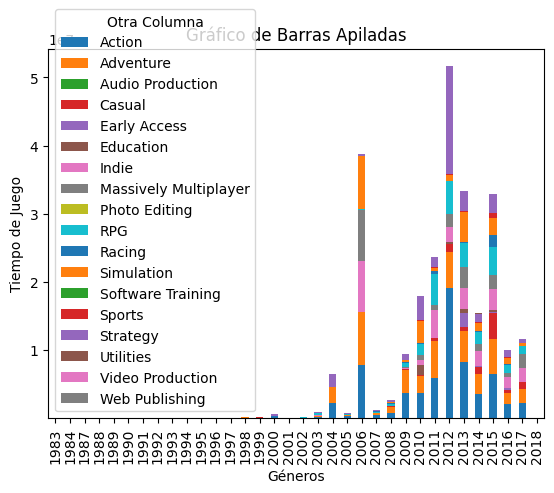

In [110]:
#se crea un pivot table para poder generar un grafico de columnas apiladas
pivot_table = df_user_for_genre.pivot_table(index='year', columns='genres', values='playtime_forever', aggfunc='sum')

pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Año')
plt.ylabel('Tiempo de Juego')
plt.title('Tiempo jugado por año y por genero')
plt.xticks(rotation=90)  #Para mayor legibilidad
plt.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Se tiene que los tiempos de juego por debajo de 2003 eran muy bajos en comparacion con los años siguientes. A partir deste año se observa un crecimiento abismal en el consumo de los juegos. Por lo tanto nos centraremos en estos años para el analsis.

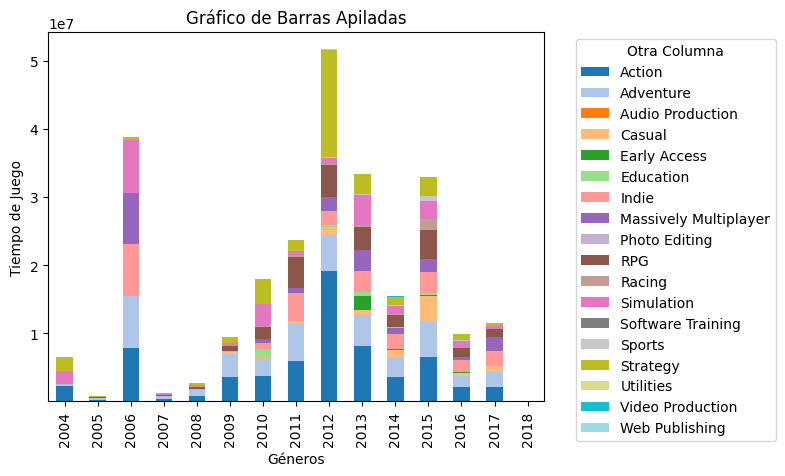

In [115]:
pivot_table = df_user_for_genre[df_user_for_genre.year>2003].pivot_table(index='year', columns='genres', values='playtime_forever', aggfunc='sum')

# Crear el gráfico de barras apiladas con Seaborn
pivot_table.plot(kind='bar', stacked=True,cmap='tab20')
plt.xlabel('Año')
plt.ylabel('Tiempo de Juego')
plt.title('Tiempo jugado por año y por genero')
plt.xticks(rotation=90) #Para mayor legibilidad
plt.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Se observa que claramente que a lo largo de los años los generos mas importante son:
- Accion
- Aventura
- RPG
- Indie
- Strategy
- Simulation
Esto ya habia sido determinado previamente.
En general, se observa que se alcanza un pico de horas maximas jugadas en 2012, año a partir del cual empieza a disminuir la cantidad de horas jugadas. Esto no se cumple en todos los generos, si bien por ejemplo para el genero de accion si se cumple, para estrategia por ejemlo simulacion ocurrrio lo contrario, en 2012 bajo mucho las horas de juego, por lo tanto no es tendencia general a todos los generos.

A continuacion se van a analizar las recomendaciones por año

In [126]:
df_user_recommend2 = df_user_recommend[(df_user_recommend.recommend) & (df_user_recommend.sentimiento.isin([1,2]))]  #Se filtran los registros que cumplen con la condicion para peretenecer al top 3 de juegos mas recomendados
df_user_recommend2 = df_user_recommend2[['year','app_name','recommend']]
df_user_not_recommend2 = df_user_recommend[(~df_user_recommend.recommend) & (df_user_recommend.sentimiento == 0)]  #Se filtran los registros que cumplen con la condicion para peretenecer al top 3 de juegos mas recomendados
df_user_not_recommend2 = df_user_not_recommend2[['year','app_name','recommend']]
df_rec = pd.concat([df_user_recommend2,df_user_not_recommend2])
df_rec[['year','recommend']].groupby('year').count

,year,recommend
0,2014,True
1,2015,True
3,2014,True
4,2013,True
5,2013,True
...,...,...
53835,2014,False
53839,2014,False
53854,2015,False
53872,2014,False


Text(0.5, 1.0, 'Reseñas positivas y negativas por año')

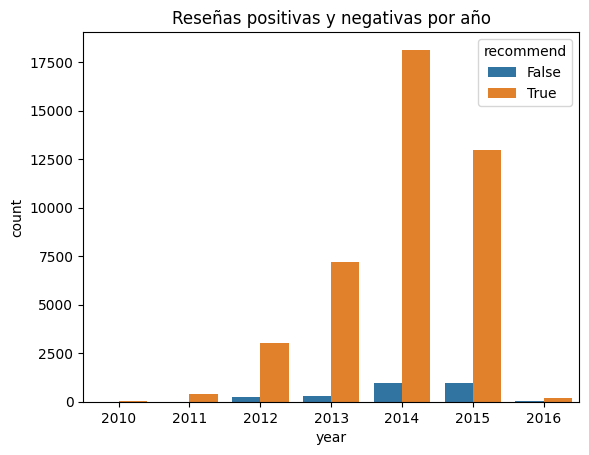

In [167]:
sns.countplot(data=df_rec,x='year',hue='recommend')
plt.title('Reseñas positivas y negativas por año')
plt.show()


Se observa que la mayoria de las reseñas fueron positivas, y que hubi una tendencia creciente hasta el 2014 en general por parte de los usuarios a comentar sobre los juegos. No se tiene suficientes datos como para concluir que la tendencia a comentar los juegos actualmente esta en caida, pero al menos para el año 2015 fue inferior que para el año 2014. Para el año 2016 se tiene extremadamente pocas reseñas, que pueden no haber sido subidas adecuadamente a la pagina porque como se observa, la ultima reseña cargada fue en agosto por lo que se esperaria que sea mayor. Esto tambien puede deberse a la forma en que se imputaron los datos faltantes, ya que cuando el mes de la fecha de posteo era posterior al mes de la fecha de la ultima edicion, se tomana la fecha del ultimo posteo pero sumando un año mas ya que no tendria sentido de otra forma.

In [130]:
df_user_recommend.date.max()

Timestamp('2016-09-08 00:00:00')

A continuacion vamos a determinar si existe una relacion entre el tiempo de juego y su precio

In [151]:
df_steam_games_ml2 = df_steam_games_ml[['id','price','year']]
# Se toma por 0 los valores que no son numericos en la columna precio
df_steam_games_ml2['price'] = df_steam_games_ml2['price'].apply(lambda x: 0.0 if type(x) == str else x)
df_merge_price_time = pd.merge(df_steam_games_ml2, df_items[['item_id','playtime_forever']], left_on='id', right_on='item_id', how='inner')

<ipython-input-151-2a000cd7b1c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steam_games_ml2['price'] = df_steam_games_ml2['price'].apply(lambda x: 0.0 if type(x) == str else x)


In [154]:
df_merge_price_time.drop('item_id',axis=1,inplace=True)

In [156]:
df_merge_price_time[df_merge_price_time.playtime_forever !=0]

,id,price,year,playtime_forever
0,282010,9.99,1997,5.0
4,282010,9.99,1997,13.0
5,282010,9.99,1997,110.0
6,282010,9.99,1997,13.0
7,282010,9.99,1997,8.0
...,...,...,...,...
4232614,80,9.99,2004,203.0
4232616,80,9.99,2004,244.0
4232617,80,9.99,2004,7.0
4232623,80,9.99,2004,9.0


<Axes: xlabel='price', ylabel='playtime_forever'>

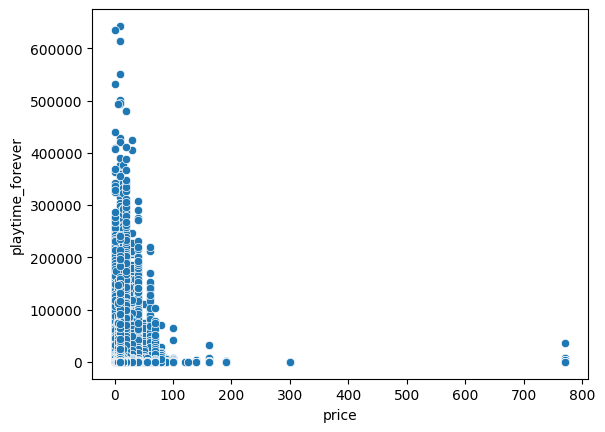

In [158]:
sns.scatterplot(data=df_merge_price_time,x='price',y='playtime_forever')
plt.title('Relacion entre tiempo juego y precio')
plt.xlabel('precio(usd)')
plt.ylabel('tiempo(min)')
plt.title('Precio promedio de juegos por año')
plt.show()

Si bien ya se observa una tendencia, eliminaremos los outliers

Text(0.5, 1.0, 'Relacion entre tiempo juego y precio')

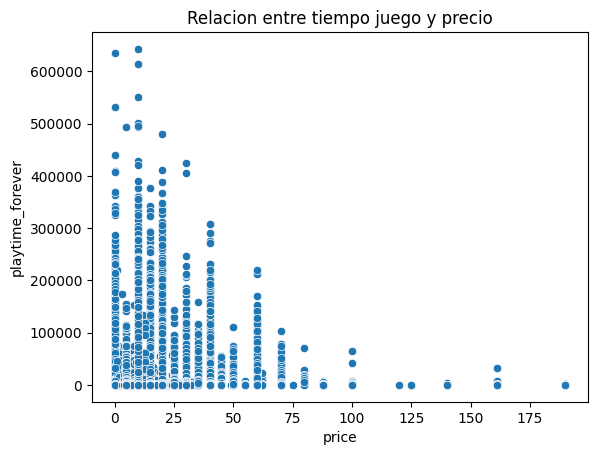

In [169]:
sns.scatterplot(data=df_merge_price_time[df_merge_price_time.price<200],x='price',y='playtime_forever')
plt.title('Relacion entre tiempo juego y precio')
plt.xlabel('precio(usd)')
plt.ylabel('tiempo(min)')
plt.show()

De esta manera se observa una clara tendencia en la que los juegos mas jugados son los mas economicos.

A continuacion se va a analizar como fueron variando a lo largo del tiempo el precio de los juegos:

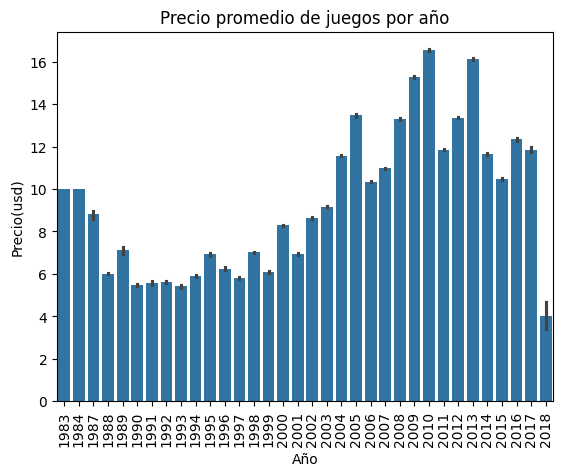

In [171]:
sns.barplot(data=df_merge_price_time,x='year',y='price')
plt.xlabel('Año')
plt.ylabel('Precio(usd)')
plt.title('Precio promedio de juegos por año')
plt.xticks(rotation=90) #Para mayor legibilidad
plt.show()

Se observa que inicialmente eran relativamente costosos, luego en 1987 disminuyo en gran medida su precio y se mantuvo practicamente constante hasta 1999, año apartir del cual los precios se dispararon hasta que en 2010 se encontraban a mas de el doble de lo que costaban en 1999(de 6 usd a 16 aproximadamente). A partir de este año, se observa una tendencia decreciente en el precio de los juegos.

Por ultimo se estudiara en que meses se tiene una mayor afluencia de usuarios.

In [185]:
df_time_month = df_steam_games[['id','release_date']]

In [186]:
# Se cambia el tipo de dato de la columna fecha_lanzamiento a datetime
df_time_month['fecha_lanzamiento'] = pd.to_datetime(df_time_month['release_date'], errors='coerce')

#Se analiza cuantos valores nulos resultan en la columna fecha_lanzamiento
print('Nulos en columna de fecha_lanzamiento:',df_time_month['fecha_lanzamiento'].isnull().sum())

#Como el numero de nulos en la fecha_lanzamiento es considerable, se analiza si se perdieron fechas o que valores se tenian en estos registros el la columna fecha_lanzamiento
print('Valores que se tomaron en fecha_lanzamiento como nulos:',df_time_month['release_date'][df_time_month['fecha_lanzamiento'].isnull()].unique())

#Como se observa los nulos en fecha_lanzamiento en general indican que el juego todavia no fue lanzado aun o que estan proximos a ser lanzados, ademas de valores que previamente eran nulos, se eliminan estos registros ya que no suman a nuestro analisis ya que nos interesan los juegos que ya fueron jugados
df_time_month = df_time_month.dropna(subset='fecha_lanzamiento')

#Se crea una columna con los años donde se lanzo el juego
df_time_month['month'] = [fecha.month for fecha in df_time_month['fecha_lanzamiento']]

#Se eliminan las demas columnas relacionadas a la fecha
df_time_month = df_time_month.drop(['fecha_lanzamiento','release_date'],axis=1)

Nulos en columna de fecha_lanzamiento: 2241
Valores que se tomaron en fecha_lanzamiento como nulos: [nan 'Soon..' 'Beta测试已开启' 'Coming Soon' 'Q2 2017' 'TBA' "When it's done"
 'coming soon' 'Q2 2018' 'Winter 2017' 'soon' '14 July' 'Summer 2017'
 'Spring 2018' 'Winter 2018' 'To be Announced' 'TBD' 'Fall 2017' 'Q1 2018'
 'Январь 2018' 'Soon' 'First quarter of 2018' 'H2 2018' '2018年初頭発売予定'
 'Please wait warmly' 'early access' 'SOON' 'Coming Soon/Próximamente'
 '2018 [Now get free Pre Alpha]' '1st Quarter 2018' '预热群52756441'
 '2018年1月' 'Coming soon' 'Fall 2018'
 '0̵1̴0̵0̶1̷0̶0̵0̴ ̴0̶0̶1̶1̶0̷0̶1̵1̴ ̸0̶0̶1̶1̵0̶1̷0̴0̵ ̴0̶1̷0̸1̵0̷0̴1̶0̴ ̴0̷0̴1̷1̶0̶1̵1̷1̵ ̵'
 '"""Soon"""' 'Spring 2017' 'Demo coming soon.' 'Coming 2017'
 'Not yet available' "C'est bientôt...                    (ou pas)"
 'Q4 2017' 'Early 2018' 'Datachunks conflicted. Be vigiliant.'
 'Q2 2018 (Tentative)' 'Demo is available now!' 'Play Beta in demo!'
 '2017 Q4' 'Coming Soon!' 'Early Spring 2018' 'TBA 2017' 'To be announced'
 'When 

<ipython-input-186-d7dfceaf400c>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_time_month['fecha_lanzamiento'] = pd.to_datetime(df_time_month['release_date'], errors='coerce')
<ipython-input-186-d7dfceaf400c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_month['fecha_lanzamiento'] = pd.to_datetime(df_time_month['release_date'], errors='coerce')
<ipython-input-186-d7dfceaf400c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-196-8241e9ceb0ad>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(nombres_meses)


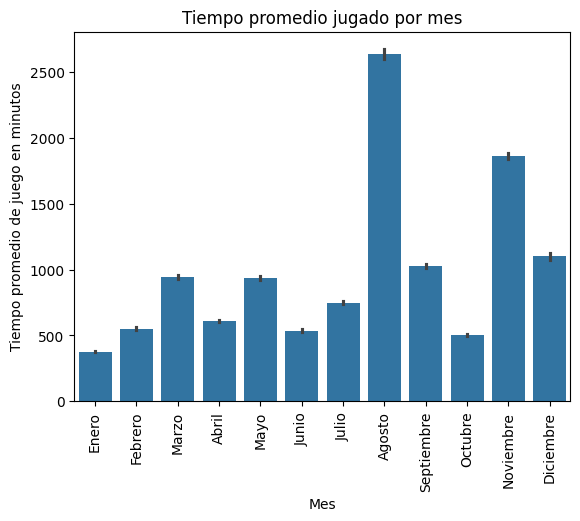

In [196]:
df_merge_time_month = pd.merge(df_time_month, df_items[['item_id','playtime_forever']], left_on='id', right_on='item_id', how='inner').drop('id',axis=1) #Se unen los df para relacionar la columna de mes con la de tiempo de juego
sns.barplot(df_merge_time_month,x='month',y='playtime_forever')
nombres_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plt.xlabel('Mes')
plt.ylabel('Tiempo promedio de juego en minutos')
plt.title('Tiempo promedio jugado por mes')
plt.gca().set_xticklabels(nombres_meses)
plt.xticks(rotation=90)
plt.show()


Se observa que el mes mas jugado es agosto, seguido por noviembre. Luego tambien es interesante observar que en marzo, mayo septiembre y diciembre el tiempo promedio jugado es similar.